In [1]:
from testproblems import random_problem_with_artifacts
from datastructures.api import OPT, VAR, COMP, SOLVER, OBJ
from datastructures.graphutils import edges_E, all_components, all_variables, sources, edges_to_Ein_Eout, flat_graph_formulation, root_solver, namefromid
from datastructures.operators import sort_scc, reorder_merge_solve
from datastructures.workflow import get_f, order_from_tree, default_solver_options, mdao_workflow, implicit_comp_name
from datastructures.workflow_mdao import mdao_workflow_with_args
from datastructures.assembly import build_archi
from datastructures.assembly import root_sources
from datastructures.execution import Component
from datastructures.runpipeline import nestedform_to_mdao
from datastructures.tearing import min_max_scc2, dir_graph
from datastructures.polycasebuilder import generate_random_polynomials, eqv_to_edges_tree
import networkx as nx
import numpy as np
from datastructures.rendering import render_incidence
import time
import openmdao.api as om

In [2]:
def add_obj(inputids, var_mapping, edges, tree, components):
    inputvars = [var_mapping[elt][0] for elt in inputids]
    fobj = sum([(elt-1)**2 for elt in inputvars])
    newidx = 'obj'#len(edges[1])
    c = Component.fromsympy(fobj, component=newidx, arg_mapping=var_mapping)
    edges[0][newidx] = c.inputs
    edges[1][newidx] = c.outputs
    tree[0][newidx] = 1
    return components+[c], newidx

In [3]:
def generate_mdao_prob(inputids, var_mapping, edges, tree, components, mdf=True):
    components, newidx = add_obj(inputids, var_mapping, edges, tree, components) # mutates edges and tree aswell
    solvers_options = {1: {'type': OPT, 'disp':False}, 2:{'maxiter':200}}
    comp_options = {newidx:OBJ}
    dv = root_sources(edges, tree)
    for elt in dv:
        tree[2][elt] = 1
    var_options = {}
    nodetyperepr = {VAR: 'x_{}', COMP: 'f_{}', SOLVER: 's_{}'}
    prob, mdao_in, groups, formulation,merge_order = nestedform_to_mdao(edges, tree, components, solvers_options, comp_options, var_options, nodetyperepr, mdf)
    return prob, groups, formulation, merge_order

In [4]:
def measure_optimization(prob, groups, Stree):
    try:
        prob.set_solver_print(-1)
        tic = time.perf_counter()
        prob.run_driver()
        toc = time.perf_counter()
        total_iters = 0
        for key,var in Stree.items():
            parent = groups['s_{}'.format(var)]
            total_iters += getattr(parent, 's_{}'.format(key)).iter_count_apply
        objiter = groups['s_1'].f_obj.iter_count
        return prob.driver.result.fun, total_iters, objiter, toc-tic
    except:
        return 999, None, None, None

In [5]:
inputids_store = {}

In [6]:
def min_max_scc_calculations(eq_incidence=None, edges_varonleft=None, varidxs=None, eqnidxs=None, outset=None, probtype=None, seed_poly=None, mdf=None, **kwargs):
    if probtype == 2:
        xsol, m = min_max_scc2(edges_varonleft, varidxs, eqnidxs, timeout=100)
        if xsol:
            outset = dict((right, left) for left, right in edges_varonleft if xsol[left, right] > 0.5)
        else:
            return 999, 999, None, None, None
    D = nx.DiGraph(dir_graph(edges_varonleft, eqnidxs, outset.items()))
    sccsize = max(len(elt) for elt in nx.strongly_connected_components(D))//2
    rng = np.random.default_rng(seed_poly)
    _, var_mapping, edges, tree, components = generate_random_polynomials(eq_incidence, outset, len(eqnidxs), rng)
    identifier = (kwargs['m'], kwargs['n'], kwargs['sparsity'], kwargs['seed'])
    if probtype == 2:
        inputids = sources(*edges_to_Ein_Eout(edges))
        inputids_store[identifier] = inputids
    else:
        inputids = inputids_store[identifier]
    prob, groups, formulation,_ = generate_mdao_prob(inputids, var_mapping, edges, tree, components, mdf)
    optim_results = measure_optimization(prob, groups, formulation[1][1])
    return (sccsize,)+optim_results

In [7]:
def generate_artifacts(m,n,sparsity,seed,probtype,seed_poly,mdf):
    kwargs = random_problem_with_artifacts(m,n,seed,sparsity)
    kwargs.update({
        "seed_poly": seed_poly,
        "probtype": probtype,
        "mdf": mdf
    })
    return kwargs

## Chapter example

In [8]:
kwargs = generate_artifacts(10,15,1.5,42,1,0,False)

In [9]:
#inputids_store

In [10]:
#min_max_scc_calculations(**kwargs)

In [11]:
edges_varonleft, varidxs, eqnidxs = (kwargs[key] for key in ['edges_varonleft','varidxs','eqnidxs'])

In [12]:
xsol, m = min_max_scc2(edges_varonleft, varidxs, eqnidxs, timeout=100)
outset = dict((right, left) for left, right in edges_varonleft if xsol[left, right] > 0.5)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-02-25


In [13]:
D = nx.DiGraph(dir_graph(edges_varonleft, eqnidxs, outset.items()))
minssc = max(len(elt) for elt in nx.strongly_connected_components(D))//2

In [14]:
minssc

3

In [15]:
#outset=kwargs["outset"]

In [16]:
mdf = False

In [17]:
eq_incidence = kwargs["eq_incidence"]

In [21]:
rng = np.random.default_rng(kwargs["seed_poly"])
polys, var_mapping, edges, tree, components = generate_random_polynomials(eq_incidence, outset, len(kwargs["eqnidxs"]), rng)
#inputids = sources(*edges_to_Ein_Eout(edges))
identifier = (kwargs['m'], kwargs['n'], kwargs['sparsity'], kwargs['seed'])
#inputids_store[identifier] = inputids
inputids = inputids_store[identifier]

In [23]:
edges_sand = ({comp:tuple(var-10 for var in compvars) for comp, compvars in eq_incidence.items()}, {comp: (None,) for comp in eq_incidence.keys()},{})
tree_sand = (tree[0],{},{var:1 for var in range(len(varidxs))})
edges = edges_sand
tree = tree_sand

In [24]:
components, newidx = add_obj(inputids, var_mapping, edges, tree, components) # mutates edges and tree aswell
solvers_options = {1: {'type': OPT, 'disp':True}, 2:{'maxiter':30}}
comp_options = {newidx:OBJ}
dv = root_sources(edges, tree)
for elt in dv:
    tree[2][elt] = 1
var_options = {}
nodetyperepr = {VAR: 'x_{}', COMP: 'f_{}', SOLVER: 's_{}'}

In [25]:
G = flat_graph_formulation(*edges)
merge_order = sort_scc(G)
merge_parent = root_solver(tree) # all merged components will have this solver as the parent
ordered_edges, ordered_tree = reorder_merge_solve(edges, tree, merge_order, merge_parent, mdf)

In [26]:
namingfunc = namefromid(nodetyperepr)
sequence = order_from_tree(ordered_tree[0], ordered_tree[1], ordered_edges[1])
solvers_options = default_solver_options(ordered_tree, solvers_options)
wf = mdao_workflow(sequence, solvers_options, comp_options, var_options)
lookup_f = get_f(components, ordered_edges)
wfmdao = mdao_workflow_with_args(wf, lookup_f, namingfunc)
prob, mdao_in, groups = build_archi(ordered_edges, ordered_tree, wfmdao, namingfunc)

In [29]:
#From Homotopy method
sol = [9.044275498572112, -1.8, 4.0, 1.5, 5.919614960128627, 1.7068591866023533, -0.49361527546164685, 0.9722222222222221, 1.0, 1.0, -0.09235334150723525, 1.0, 9.624869813933593, 1.0, 1.0]
for idx,elt in enumerate(sol):
    prob.set_val('x_{}'.format(idx), 1.001*elt)

In [30]:
prob.run_driver();

Singular matrix E in LSQ subproblem    (Exit mode 5)
            Current function value: [0.45284529]
            Iterations: 88
            Function evaluations: 92
            Gradient evaluations: 88
Optimization FAILED.
Singular matrix E in LSQ subproblem
-----------------------------------


In [434]:
groups['s_2'].iter_count_apply

48

In [27]:
from utils import normalize_name

In [28]:
vrs = list(range(len(kwargs["varidxs"])))
reqeqs = kwargs["eq_incidence"]
n_eqs = len(kwargs["eqnidxs"])
print('@var {}'.format(", ".join(['x_{}'.format(vr) for vr in vrs])))
print('@var λ[1:{}];'.format(n_eqs))
for key, var in polys.items():
    print('h{}={};'.format(key, normalize_name(str(var), keep_underscore=True)))
print('vars=[{}]'.format(", ".join(['x_{}'.format(vr) for vr in vrs])))
print('dfdx=[{}]'.format(", ".join([str(0) if vr not in inputids else 'x_{}'.format(vr) for vr in vrs])))
print('h=[{}];'.format(", ".join(['h{}'.format(eq) for eq in polys.keys()])))

@var x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_10, x_11, x_12, x_13, x_14
@var λ[1:10];
h0=0.6*x_12*x_6 + 0.8*x_3*x_7 + 0.2*x_4 + 0.5;
h1=0.5*x_1*x_13*x_9 - 0.9*x_10*x_12 - 0.6*x_14 + 0.7;
h2=0.3*x_11*x_12 + 0.2*x_2*x_3*x_5 - 0.8*x_4*x_8 - 0.2;
h3=0.4*x_1*x_14*x_7 + 0.3*x_11*x_8 + 0.4;
h4=0.1*x_14*x_4 + 0.4*x_6*x_7 - 0.4;
h5=-0.3*x_14*x_6*x_7 + 0.1*x_3*x_5 - 0.4;
h6=0.8*x_13*x_9 - 0.2*x_14*x_3 - 0.5;
h7=0.2*x_2 - 0.8;
h8=0.8*x_0*x_5 - 0.3*x_12*x_2 - 0.7*x_9 - 0.1;
h9=-0.5*x_1*x_11*x_8 - 0.9;
vars=[x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_10, x_11, x_12, x_13, x_14]
dfdx=[0, 0, 0, 0, 0, 0, 0, x_7, 0, x_9, 0, 0, x_12, x_13, x_14]
h=[h0, h1, h2, h3, h4, h5, h6, h7, h8, h9];


In [31]:
prob.list_problem_vars(cons_opts=['lower', 'upper', 'equals'])

----------------
Design Variables
----------------
name  val               size  
----  ----------------  ---- 
x_0   [2.45245204e+10]  1     
x_1   [-3.6219042]      1     
x_2   [4.]              1     
x_3   [0.80164996]      1     
x_4   [8.77975331]      1     
x_5   [1.10297916e-10]  1     
x_6   [-3.51795195]     1     
x_7   [0.36450115]      1     
x_8   [0.14463463]      1     
x_9   [0.91290139]      1     
x_10  [-1.34998288]     1     
x_11  [3.43607981]      1     
x_12  [1.17952744]      1     
x_13  [0.91290141]      1     
x_14  [1.03980029]      1     

-----------
Constraints
-----------
name  val                size  lower  upper  equals  
----  -----------------  ----  -----  -----  ------ 
eq0   [-4.48530102e-14]  1     0.0    0.0    None    
eq1   [-7.27973237e-13]  1     0.0    0.0    None    
eq4   [7.5606188e-14]    1     0.0    0.0    None    
eq6   [9.70334924e-14]   1     0.0    0.0    None    
eq7   [0.]               1     0.0    0.0    None    
eq3   [7.

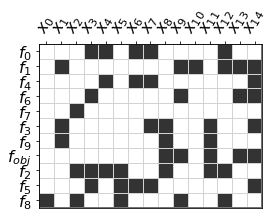

In [484]:
#synthetic_initial_blockmdf.png
render_incidence(ordered_edges, ordered_tree, figname='synthetic_opt_sand.png', save=True, figsize=((4,4)));

## Full scale

In [135]:
from experimentutils import run_calculations
from itertools import product
import pandas as pd

In [136]:
def generate_problem(*args, df=None):
    data = []
    colnames = ["m", "ncoeff", "n", "sparsity", "seed", "poly_seed", "prob_type","mdf"]
    for m,ncoeff,sparsity,seed,poly_seed,prob_type,mdf in product(*args):
        n=m+int(ncoeff*m)
        if df is None or ((m, ncoeff, n, sparsity, seed, poly_seed, prob_type,mdf) not in df[colnames].itertuples(index=False)):
            data.append([m, ncoeff, n, sparsity, seed, poly_seed, prob_type,mdf])
    df2 = pd.DataFrame(data, columns=colnames)
    if df is not None:
        df2 = pd.concat([df, df2], ignore_index=True)
    return df2

In [137]:
df = generate_problem((10,),(0.5,),(1.,),range(10),range(10),(2,1),(True,False)) #df

In [149]:
df.to_csv('results_10x15_sparsity_1.csv')

In [139]:
fxs = {('maxscc', 'fobj', 'solveriter', 'optiter', 'time'): min_max_scc_calculations}

In [148]:
run_calculations(df, fxs, iter_cycles=400, filename=None, commonartifacts=generate_artifacts, 
                 argnames=["m", "n", "sparsity", "seed", "prob_type", "poly_seed", "mdf"])

IntProgress(value=0, max=400)

C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\solvers\nonlinear\newton.py:209: RuntimeWarning: invalid value encountered in double_scalars
  rec.rel = norm / norm0
C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\solvers\solver.py:605: RuntimeWarning: invalid value encountered in double_scalars
  self._mpi_print(self._iter_count, norm, norm / norm0)
C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\solvers\solver.py:612: RuntimeWarning: invalid value encountered in double_scalars
  while self._iter_count < maxiter and norm > atol and norm / norm0 > rtol and not stalled:


Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------


C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\core\total_jac.py:1596: DerivativesWarning:Design variables [('inp.x_4', inds=[0])] have no impact on the constraints or objective.


Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------


C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\core\total_jac.py:1596: DerivativesWarning:Design variables [('inp.x_6', inds=[0]), ('inp.x_10', inds=[0])] have no impact on the constraints or objective.


Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Singular matrix E in LSQ subproblem
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------


C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\core\total_jac.py:1596: DerivativesWarning:Design variables [('inp.x_4', inds=[0]), ('inp.x_5', inds=[0]), ('inp.x_14', inds=[0])] have no impact on the constraints or objective.


Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------


C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\core\total_jac.py:1596: DerivativesWarning:Design variables [('inp.x_0', inds=[0])] have no impact on the constraints or objective.


Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------


C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\core\total_jac.py:1596: DerivativesWarning:Design variables [('inp.x_0', inds=[0])] have no impact on the constraints or objective.


Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------


C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\core\total_jac.py:1596: DerivativesWarning:Design variables [('inp.x_0', inds=[0])] have no impact on the constraints or objective.


Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------


C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\core\total_jac.py:1596: DerivativesWarning:Design variables [('inp.x_12', inds=[0]), ('inp.x_14', inds=[0])] have no impact on the constraints or objective.


Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------


C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\core\total_jac.py:1596: DerivativesWarning:Design variables [('inp.x_13', inds=[0])] have no impact on the constraints or objective.


Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------


<lambdifygenerated-10247>:2: RuntimeWarning: overflow encountered in square
  return (x_0 - 1)**2 + (x_10 - 1)**2 + (x_13 - 1)**2 + (x_3 - 1)**2 + (x_9 - 1)**2
C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\core\total_jac.py:1596: DerivativesWarning:Design variables [('inp.x_1', inds=[0]), ('inp.x_6', inds=[0]), ('inp.x_7', inds=[0])] have no impact on the constraints or objective.


Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Singular matrix E in LSQ subproblem
-----------------------------------
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------


<lambdifygenerated-10991>:2: RuntimeWarning: overflow encountered in square
  return (x_0 - 1)**2 + (x_10 - 1)**2 + (x_13 - 1)**2 + (x_3 - 1)**2 + (x_9 - 1)**2


Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Singular matrix E in LSQ subproblem
-----------------------------------


<lambdifygenerated-12355>:2: RuntimeWarning: overflow encountered in square
  return (x_1 - 1)**2 + (x_10 - 1)**2 + (x_13 - 1)**2 + (x_2 - 1)**2 + (x_5 - 1)**2
C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\core\total_jac.py:1567: DerivativesWarning:Constraints or objectives [('f_obj.objobj', inds=[0])] cannot be impacted by the design variables of the problem.
C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\core\total_jac.py:1596: DerivativesWarning:Design variables [('inp.x_2', inds=[0]), ('inp.x_4', inds=[0]), ('inp.x_6', inds=[0]), ('inp.x_12', inds=[0]), ('inp.x_13', inds=[0])] have no impact on the constraints or objective.


Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Singular matrix E in LSQ subproblem
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------


C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\core\total_jac.py:1596: DerivativesWarning:Design variables [('inp.x_7', inds=[0]), ('inp.x_8', inds=[0]), ('inp.x_14', inds=[0])] have no impact on the constraints or objective.


Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
